In [199]:
import pandas as  pd
import json
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.core.display import display, HTML
import numpy  as np
from imblearn.over_sampling import SMOTE

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [68]:
import numpy as np
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
import seaborn as sns
def plot_metrics(dataframe, title="",*, target="target"):
    fig, ax = plt.subplots(figsize=(10,10))
    sns.distplot(dataframe[dataframe[target] == 0]["prediction"], label="Cero", ax=ax)
    sns.distplot(dataframe[dataframe[target] == 1]["prediction"], label="Uno", ax=ax)
    plt.legend()
    plt.title(title)
    plt.show()
    print("ROC {}".format(roc_auc_score(dataframe[target], dataframe["prediction"])))
    exp_series = pd.Series(dataframe[target])
    pred_series = pd.Series(dataframe["pred"])
    array_df= pd.crosstab(exp_series, pred_series, rownames=['Actual'], colnames=['Predicted'],margins=True)
    print("Recall: {}".format(array_df[1][1]/array_df["All"][1]))
    precision = array_df[1][1]/array_df[1]["All"]
    precision_real = array_df["All"][1]/array_df["All"]["All"]
    print("Precisión: {}".format(precision))
    print("Precisión observada(real): {}".format(precision_real))
    print("Mejora en precisión: {}".format(precision/precision_real))
    display(pd.crosstab(exp_series, pred_series, rownames=['Actual'], colnames=['Predicted'],margins=True))

In [142]:
one_hot_dict = {
        "device_score":[1,2,3,4,5],
        "establecimiento":['Super', 'no-definido', 'MPago', 'Abarrotes', 'Farmacia', 'Restaurante'],
        "os": ['ANDROID', '.', 'WEB', '%%'],
        "ciudad": ['Merida', 'Guadalajara', 'Toluca', 'Monterrey', 'no-definido'],
        "weekday":['work_week', 'end_week'],
        "monthday": ['lasthalf_month', 'middle_month', 'firsthalf_month', 'end_month'],
        "momentday": ['noche', 'manana', 'madrugada', 'tarde']
    
}
one_hot_fields =  []
def get_onehot_mappings(dataframe):
    global one_hot_fields
    one_hot_fields =  []
    for fld in one_hot_dict.keys():
        for vl in one_hot_dict[fld]:
            dataframe["{}_{}".format(fld,vl)] = dataframe[fld].apply(lambda el: 1 if el == vl else 0 )
            one_hot_fields.append("{}_{}".format(fld,vl))
    return dataframe

In [143]:
def interval_month(day):
    if ((day >= 27) | (day <=3)):
        return "end_month"
    if ((day >= 12) & (day <=18)):
        return "middle_month"
    if (day < 12):
        return "firsthalf_month"
    if (day > 18):
        return "lasthalf_month"
    return "default"

def week_day(day):
    if day >= 4:
        return "end_week"
    
    return "work_week"
def get_time(day):
    if day<=6:
        return "madrugada"
    
    if day<=12:
        return "manana"
    
    if day<=19:
        return "tarde"
    return "noche"

In [144]:
# Lunes => 0 Domingo => 6

In [145]:
def prepare_data(dataframe):
    numeric_fields = [ "monto", "hora", "linea_tc", "interes_tc", "dcto", "cashback"]
    for fld in numeric_fields:
        dataframe[fld] = pd.to_numeric(dataframe[fld]) 
    dataframe["fecha"] = pd.to_datetime(dataframe["fecha"]).dt.date
    
    dataframe["weekday"] = pd.to_datetime(dataframe["fecha"]).dt.weekday.apply(week_day)
    dataframe["monthday"] = pd.to_datetime(dataframe["fecha"]).dt.day.apply(interval_month)
    dataframe["momentday"] = dataframe["hora"].apply(get_time)
    
    # Filling genero field
    genero_moda = dataframe["genero"].mode()[0]
    dataframe["genero"] = dataframe["genero"].apply(lambda gn:  None if ((gn is None) | (gn not in ["M", "F"])) else gn)
    dataframe["genero"] = dataframe["genero"].fillna(genero_moda).apply(lambda el: 1 if el == "M" else 0)
    
    dataframe["es_fisica"] = dataframe["tipo_tc"].apply(lambda el: 0 if el ==  "Virtual" else 1)
    dataframe["is_prime"] = dataframe["is_prime"].apply(lambda el: 1 if el ==  True else 0)
    
    dataframe["mobile"] = dataframe["dispositivo"].apply(lambda dc: json.loads(dc.replace("'",'"')))
    dataframe["device_score"] = dataframe["mobile"].apply(lambda el:  el["device_score"])
    dataframe["os"] = dataframe["mobile"].apply(lambda el:  el["os"])
    
    # Adding target field
    dataframe["target"] = dataframe["fraude"].apply(lambda el: 1 if el == True else 0)
    
    # Imputting stage
    dataframe["establecimiento"] = dataframe["establecimiento"].fillna("no-definido")
    dataframe["ciudad"] = dataframe["ciudad"].fillna("no-definido")
    
    return get_onehot_mappings(dataframe)

# Preparación

In [258]:
numeric_fields = ["monto", "dcto", "linea_tc", "interes_tc", "cashback"]
categorical_vars = ["genero", "es_fisica", "is_prime"]
#one_hot_candidates = ["device_score", "establecimiento", "os", "ciudad", "weekday", "monthday", "momentday"]
dataframe = pd.read_csv("ds_challenge_apr2021.csv")
dataframe =  prepare_data(dataframe)
features_row = numeric_fields+categorical_vars+one_hot_fields
#features_selected = ['os_%%', 'genero', 'dcto', 'os_ANDROID', 'cashback', 'monto', 'interes_tc', 'linea_tc']

In [261]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
X_train, X_test, y_train, y_test = train_test_split(dataframe[features_row], dataframe["target"], test_size=0.2, random_state=1234)


La muestra comprende un total de: 21,580 registros.


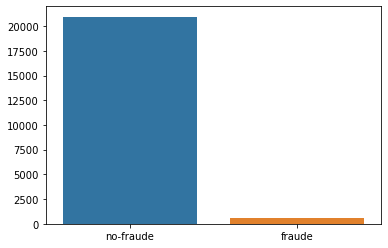

El porcentaje de 1s (633) en la muestra representa el 2.93 % del total de la población. 
Es un problema desvalanceado
33.09162717219589


In [262]:
rows_count = y_train.shape[0]
ones_count = y_train.sum()
zeros_count = rows_count - ones_count
global_precision = ones_count/rows_count
print("La muestra comprende un total de: \033[1m{:,}\033[0m registros.".format(rows_count))
sns.barplot(x=["no-fraude", "fraude"], y=[zeros_count, ones_count])
plt.show()
print("El porcentaje de 1s (\033[1m{}\033[0m) en la muestra representa el \033[1m{:.2f}\033[0m % del total de la población. \nEs un problema desvalanceado".format(ones_count, global_precision*100))
print(scale_pos_weight)

In [263]:
from imblearn.under_sampling import RandomUnderSampler
oversample = RandomUnderSampler(sampling_strategy='majority')#SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

La muestra comprende un total de: 1,266 registros.


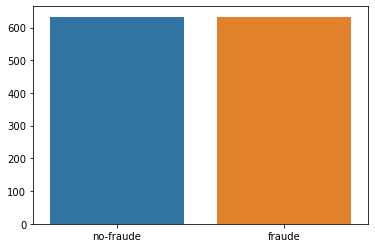

El porcentaje de 1s (633) en la muestra representa el 50.00 % del total de la población. 
Es un problema desvalanceado
33.09162717219589


In [264]:
rows_count = y_train.shape[0]
ones_count = y_train.sum()
zeros_count = rows_count - ones_count
global_precision = ones_count/rows_count
print("La muestra comprende un total de: \033[1m{:,}\033[0m registros.".format(rows_count))
sns.barplot(x=["no-fraude", "fraude"], y=[zeros_count, ones_count])
plt.show()
print("El porcentaje de 1s (\033[1m{}\033[0m) en la muestra representa el \033[1m{:.2f}\033[0m % del total de la población. \nEs un problema desvalanceado".format(ones_count, global_precision*100))
print(scale_pos_weight)

In [304]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
model = RandomForestClassifier(n_estimators=3, max_depth=4)#(n_estimators=10)#, min_samples_leaf=300)#XGBClassifier( n_estimators=2,use_label_encoder=False)
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
# Accuracy: 96.20%

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


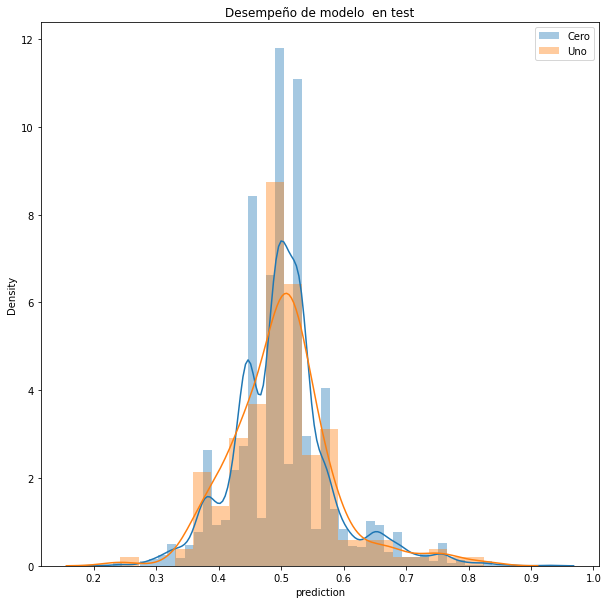

ROC 0.5006312352071165
Recall: 0.5480225988700564
Precisión: 0.033448275862068964
Precisión observada(real): 0.032808155699721966
Mejora en precisión: 1.0195110072082603


Predicted     0     1   All
Actual                     
0          2415  2803  5218
1            80    97   177
All        2495  2900  5395

In [306]:
df = pd.DataFrame()
df["target"] = y_test
df["pred"] = y_pred
df["prediction"] = y_prob[:,1]
#df["pred"] = df["prediction"].apply(lambda el: 1 if el>0.35 else 0)
plot_metrics(df, title="Desempeño de modelo  en test")

<AxesSubplot:title={'center':'Importancia de variables primer modelo : RandomForest'}>

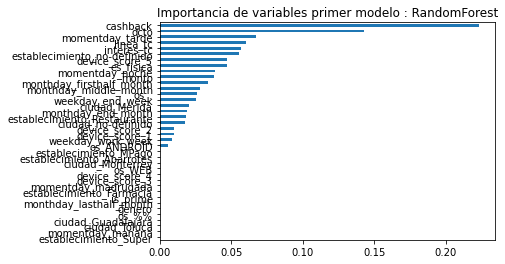

In [390]:
feat_importances = pd.Series(model.feature_importances_, index=features_row).sort_values()
feat_importances.plot(kind='barh', title="Importancia de variables primer modelo : RandomForest")

# Con las primeras 6 variables mas importantes

In [462]:
# Con las primeras 6 variables mas importantes
#feat_importances[-7:].index
features_selected =['device_score_5', 'establecimiento_no-definido', 'interes_tc',
       'linea_tc', 'momentday_tarde', 'dcto', 'cashback']

In [521]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
model_final = XGBClassifier(n_estimators=2, max_depth=3, eval_metric = "aucpr" , use_label_encoder=True )#(n_estimators=10)#, min_samples_leaf=300)#XGBClassifier( n_estimators=2,use_label_encoder=False)
model_final.fit(X_train[features_selected], y_train)
# make predictions for test data
y_pred = model_final.predict(X_test[features_selected])
y_prob = model_final.predict_proba(X_test[features_selected])

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


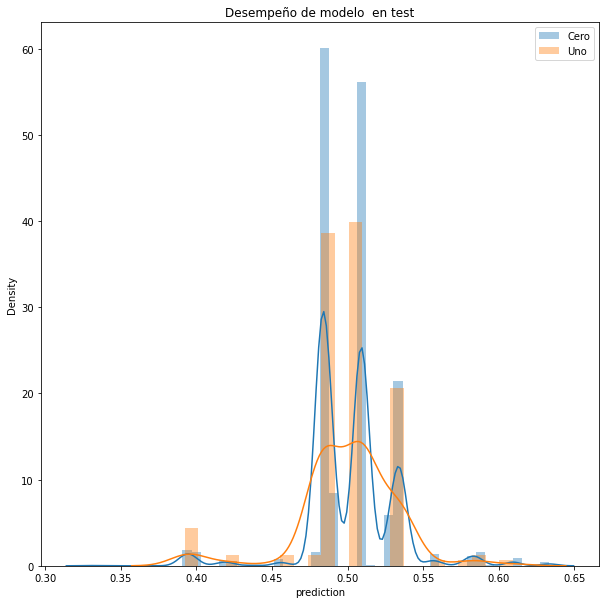

ROC 0.5054109741810725
Recall: 0.1864406779661017
Precisión: 0.03707865168539326
Precisión observada(real): 0.032808155699721966
Mejora en precisión: 1.1301656827270996


Predicted     0    1   All
Actual                    
0          4361  857  5218
1           144   33   177
All        4505  890  5395

In [571]:
df = pd.DataFrame()
df["target"] = y_test
df["pred"] = y_pred
df["prediction"] = y_prob[:,1]
df["pred"] = df["prediction"].apply(lambda el: 1 if el>=0.53 else 0)
plot_metrics(df, title="Desempeño de modelo  en test")

In [523]:
probas = [x/100 for x in range(0,21)]
vls_dict = []
for indx  in range(1,101):
    res = {}
    l_indx  = (indx-1)/100
    r_indx  = (indx)/100
    sub_df = df[(df["prediction"]>=l_indx) & (df["prediction"]<r_indx)]
    res["bin"] = "[{}-{})".format(l_indx,r_indx)
    res["pres"] = sub_df["target"].sum()/sub_df.shape[0]
    res["count"] = sub_df.shape[0]
    res["fraudes"] = sub_df["target"].sum()
    vls_dict.append(res)

invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_

In [524]:
bins = pd.DataFrame(vls_dict)

In [525]:
bins[~bins["pres"].isnull()]

bin      pres  count  fraudes
32  [0.32-0.33)  0.000000      2        0
39   [0.39-0.4)  0.060870    115        7
41  [0.41-0.42)  0.000000     17        0
42  [0.42-0.43)  0.111111     18        2
43  [0.43-0.44)  0.000000      4        0
45  [0.45-0.46)  0.071429     28        2
47  [0.47-0.48)  0.000000     27        0
48  [0.48-0.49)  0.030700   1987       61
49   [0.49-0.5)  0.011070    271        3
50   [0.5-0.51)  0.034764   1841       64
51  [0.51-0.52)  0.000000      4        0
52  [0.52-0.53)  0.026178    191        5
53  [0.53-0.54)  0.039604    707       28
55  [0.55-0.56)  0.028571     35        1
56  [0.56-0.57)  0.000000     10        0
57  [0.57-0.58)  0.027778     36        1
58  [0.58-0.59)  0.037037     54        2
59   [0.59-0.6)  0.000000      2        0
60   [0.6-0.61)  0.032258     31        1
63  [0.63-0.64)  0.000000     15        0

In [555]:
bines_builded =[ {"left":0.0,"right":0.53,  "name":"baja"},#{"left":0.49,"right":0.51, "name":"media"},
                {"left":0.53,"right":1.1, "name":"alta"}
]

In [556]:
probas = [x/100 for x in range(0,21)]
vls_dict2 = []
for elms  in bines_builded:
    res = {}
    l_indx  = elms["left"]
    r_indx  = elms["right"]
    sub_df = df[(df["prediction"]>=l_indx) & (df["prediction"]<r_indx)]
    res["bin"] = "[{}-{})".format(l_indx,r_indx)
    res["pres"] = sub_df["target"].sum()/sub_df.shape[0]
    res["count"] = sub_df.shape[0]
    res["ones"] = sub_df["target"].sum()
    res["recall"] = sub_df["target"].sum()/df["target"].sum()
    res["pob"] = sub_df.shape[0]/df.shape[0]
    vls_dict2.append(res)

In [557]:
bins2 = pd.DataFrame(vls_dict2)

In [558]:
bins2

bin      pres  count  ones    recall       pob
0  [0.0-0.53)  0.031964   4505   144  0.813559  0.835032
1  [0.53-1.1)  0.037079    890    33  0.186441  0.164968

In [560]:
0.035153/(dataframe["target"].sum()/dataframe.shape[0])

1.170681697530864

In [561]:
import shap
xg_shap_values = shap.TreeExplainer(model_final).shap_values( X_test[features_selected])

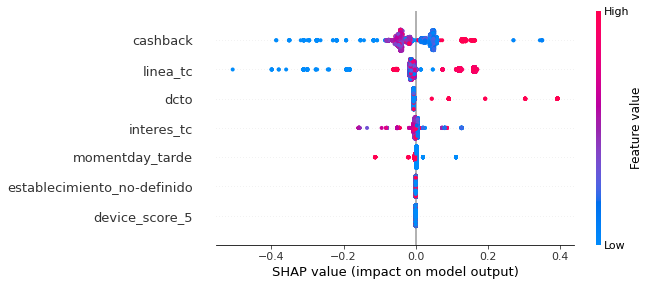

In [562]:
shap.summary_plot(xg_shap_values, X_test[features_selected])

<AxesSubplot:title={'center':'Importancia de variables primer modelo : XGboost'}>

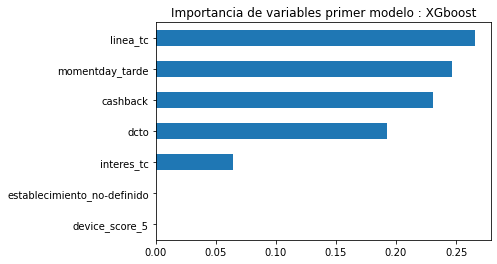

In [564]:
feat_importances = pd.Series(model_final.feature_importances_, index=features_selected).sort_values()
feat_importances.plot(kind='barh', title="Importancia de variables primer modelo : XGboost")

# Guardar modelo

In [569]:
import pickle

# save model to file
file_name = "models/model_2021_04_21.pickle.dat"
#pickle.dump(model_final, open( file_name, "wb"))

# Ejemplo de como cargarlo

In [570]:
file_name = "models/model_2021_04_21.pickle.dat"

loaded_model = pickle.load(open(file_name, "rb"))

features_selected =['device_score_5', 'establecimiento_no-definido', 'interes_tc',
       'linea_tc', 'momentday_tarde', 'dcto', 'cashback']
y_pred = loaded_model.predict(X_test[features_selected])
y_prob = loaded_model.predict_proba(X_test[features_selected])

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


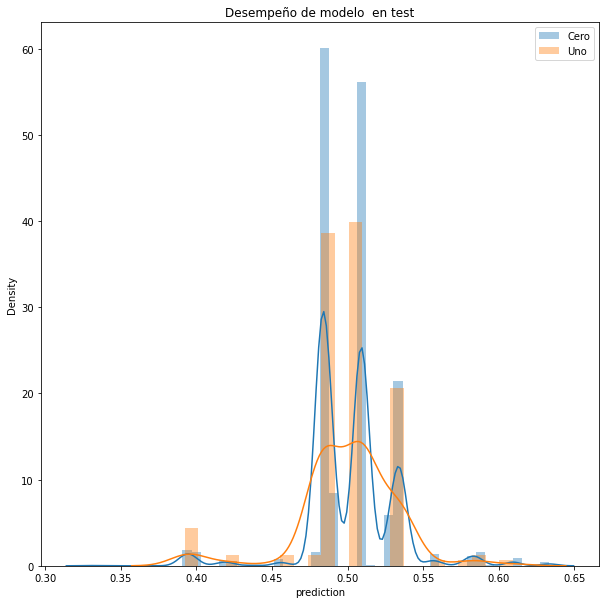

ROC 0.5054109741810725
Recall: 0.1864406779661017
Precisión: 0.03707865168539326
Precisión observada(real): 0.032808155699721966
Mejora en precisión: 1.1301656827270996


Predicted     0    1   All
Actual                    
0          4361  857  5218
1           144   33   177
All        4505  890  5395

In [571]:
df = pd.DataFrame()
df["target"] = y_test
df["pred"] = y_pred
df["prediction"] = y_prob[:,1]
df["pred"] = df["prediction"].apply(lambda el: 1 if el>=0.53 else 0)
plot_metrics(df, title="Desempeño de modelo  en test")